# Exploring Beer through reviews

[Beer Advocate](https://data.world/petergensler/beer-advocate-reviews) is a dataset containing ~500k reviews of beers.

In [0]:
from operator import itemgetter
from concurrent.futures import ProcessPoolExecutor 

import gensim
import pandas as pd

import itertools

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder

In [0]:
lemmatizer = WordNetLemmatizer()


def stem(text):
    return lemmatizer.lemmatize(text)


def map_parallel(f, iterable, **kwargs):
    with ProcessPoolExecutor() as pool:
        result = pool.map(f, iterable, **kwargs)
    return result


def retrieve_articles(start, chunksize=1000):
    return arxiv.query(
        search_query=search_query,
        start=start,
        max_results=chunksize
    )

In [0]:
def vectorize_text(examples_df):

    vectorizer = CountVectorizer(min_df=2)
    vectorized_data = vectorizer.fit_transform(examples_df['summary'])

    le = LabelEncoder()
    ohe = OneHotEncoder()
    categories_labels = le.fit_transform(valid_example_categories).reshape(-1, 1)
    categories_ohe = ohe.fit_transform(categories_labels).todense()
    return (vectorized_data, categories_labels, categories_ohe), (ohe, le)


def extract_keywords(text):
    """
    Use gensim's textrank-based approach
    """
    return gensim.summarization.keywords(
        text=text,
        lemmatize=True,
        split=True
    )


def extract_mz_keywords(text):
    """
    Use gensim's Montemurro-Zanette method implementation
    """
    return gensim.summarization.mz_keywords(
        text=stem(text),
        blocksize=32,
        split=True
    )

In [4]:
%%time

beer_df = pd.read_csv('https://query.data.world/s/ybcjhzas3vxtitpe6lxkxpdrthxc7t')

CPU times: user 7.7 s, sys: 3.48 s, total: 11.2 s
Wall time: 22.8 s


## Basic info

In [5]:
beer_df.shape

(528870, 13)

In [6]:
beer_df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_aroma', 'review_overall', 'review_palate',
       'review_profileName', 'review_taste', 'review_text', 'review_time'],
      dtype='object')

### Unique revievers

In [7]:
len(beer_df['review_profileName'].unique())

22801

### Styles

Number of styles

In [8]:
styles = beer_df['beer_style'].unique()
len(styles)

104

In [9]:
beer_df['beer_style'].value_counts()

American IPA                           43369
American Double / Imperial IPA         26106
American Double / Imperial Stout       23354
American Pale Ale (APA)                20520
American Amber / Red Ale               18731
Russian Imperial Stout                 17192
American Porter                        16601
Belgian Strong Dark Ale                15407
Fruit / Vegetable Beer                 15148
Witbier                                13535
Tripel                                 11637
American Barleywine                    10108
American Adjunct Lager                  9613
Belgian Strong Pale Ale                 8796
Hefeweizen                              8553
English Pale Ale                        7953
American Stout                          7868
Saison / Farmhouse Ale                  7835
American Pale Wheat Ale                 7771
American Strong Ale                     7458
Dubbel                                  7270
Märzen / Oktoberfest                    7012
American B

## Reviews

In [0]:
review_texts = beer_df['review_text'].dropna()

In [11]:
%%time
text_lengths = review_texts.str.split().apply(len)

CPU times: user 13.3 s, sys: 2.14 s, total: 15.4 s
Wall time: 15.4 s


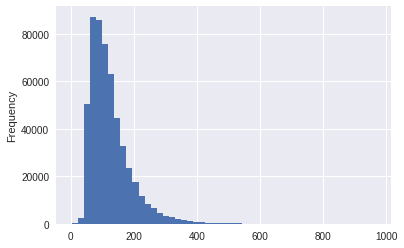

In [12]:
text_lengths.plot.hist(bins=50);

## Keywords

In [14]:
%%time

example_review_keywords = pd.Series(list(map_parallel(extract_keywords, review_texts.loc[:10000])))

CPU times: user 6.06 s, sys: 872 ms, total: 6.93 s
Wall time: 2min 1s


In [15]:
example_review_keywords

0                                                [orange]
1                                 [light, red, drinkable]
2                                   [light, roast, beige]
3                                     [good, note, fresh]
4       [beer, goodness, bitter, like, brass, glass, c...
5       [finish, liked, white, head, goblet, pour, clo...
6            [ginger, nice, simple, white, beer, caramel]
7       [light, malt beverage, beers, white, summer, o...
8              [golden, head, cheap, good, normal, lager]
9       [lagers, bodied, soft, session, mysterious, de...
10      [beer, ginger, throat, astringent, straw, spic...
11      [beer, white, aroma sharply, taste, clear, pre...
12                           [light, honey, ginger, good]
13      [beer, ginger, golden, white, review, belgium,...
14                          [lacking, flavors, chocolate]
15      [quality, taps, bacterial, ashland, control, m...
16      [light, taste, orange, bitter, summer, aggress...
17      [smoke

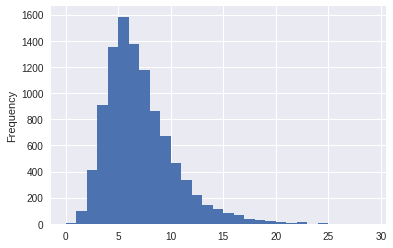

In [21]:
example_keyword_lengths = example_review_keywords.apply(len)
max_keywords_length = example_keyword_lengths.max()
example_keyword_lengths.plot.hist(bins=max_keywords_length);